In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [8]:
pd.set_option('display.max_colwidth', None)

# Przygotowanie danych

In [9]:
data_path = "../../data/4_tanks/data/"

In [10]:
# dane bez zakłóceń
df_train = pd.read_csv(data_path+"result_ol_without_noise_uczące_v3.csv", sep=';', index_col=0)
df_val = pd.read_csv(data_path+"result_ol_without_noise_walidacyjne_v3.csv", sep=';', index_col=0)
df_test = pd.read_csv(data_path+"result_ol_without_noise_testowe_v3.csv", sep=';', index_col=0)
dataset_name = "bez zakłóceń"

In [11]:
# # dane z zakłóceniami
# df_train = pd.read_csv(data_path+"result_ol_with_noise_uczące_v3.csv", sep=';', index_col=0)
# df_val = pd.read_csv(data_path+"result_ol_with_noise_walidacyjne_v3.csv", sep=';', index_col=0)
# df_test = pd.read_csv(data_path+"result_ol_with_noise_testowe_v3.csv", sep=';', index_col=0)
# dataset_name = "z zakłóceniami"

In [12]:
df_train.head()

,q_A [cm^3/s],q_B [cm^3/s],q_d1 [cm^3/s],q_d2 [cm^3/s],q_d3 [cm^3/s],q_d4 [cm^3/s],x1 [cm],x2 [cm],x3 [cm],x4 [cm]
0,452.78,555.56,0.0,0.0,0.0,0.0,65.000000,66.000000,65.000000,66.000000
1,452.78,555.56,0.0,0.0,-0.0,0.0,64.984326,65.937304,65.038198,65.992639
2,452.78,555.56,0.0,-0.0,0.0,-0.0,64.971213,65.878615,65.074774,65.985573
3,452.78,555.56,0.0,0.0,-0.0,-0.0,64.960438,65.823672,65.109799,65.978790
4,452.78,555.56,0.0,-0.0,0.0,-0.0,64.951795,65.772231,65.143339,65.972278


In [13]:
def transform_column_name(df):
    df.columns = [col[0] for col in df.columns.str.split()]
    return df

In [14]:
df_train = transform_column_name(df_train)
df_val = transform_column_name(df_val)
df_test = transform_column_name(df_test)

In [15]:
qa_max = round(3260000/3600, 2)
qa_min=0
qb_max = round(4000000/3600)
qb_min=0
x_max = 136
x_min = 20

In [16]:
def min_max_scale(s, min_value, max_value):
    return (s-min_value)/(max_value - min_value)

In [17]:
def min_max_scale_df(df):
    df['q_A'] = min_max_scale(df['q_A'], qa_min, qa_max)
    df['q_B'] = min_max_scale(df['q_B'], qb_min, qb_max)
    df['x1'] = min_max_scale(df['x1'], x_min, x_max)
    df['x2'] = min_max_scale(df['x2'], x_min, x_max)
    df['x3'] = min_max_scale(df['x3'], x_min, x_max)
    df['x4'] = min_max_scale(df['x4'], x_min, x_max)
    return df

In [18]:
df_train = min_max_scale_df(df_train)
df_val = min_max_scale_df(df_val)
df_test = min_max_scale_df(df_test)

In [20]:
def add_delay(df, col, steps=1):    
    df[col+f'(k-{steps})'] = df[col].shift(steps)
    return df

In [22]:
cols_delay = ['q_A', 'q_B', 'x1', 'x2', 'x3', 'x4']
for col in cols_delay:
    df_train = add_delay(df_train, col, 1)
    df_val = add_delay(df_val, col, 1)
    df_test = add_delay(df_test, col, 1)
    cols_delay = ['x1', 'x2', 'x3', 'x4']
for col in cols_delay:
    df_train = add_delay(df_train, col, 2)
    df_val = add_delay(df_val, col, 2)
    df_test = add_delay(df_test, col, 2)

In [23]:
df_train.dropna(inplace=True)
df_val.dropna(inplace=True)
df_test.dropna(inplace=True)

In [24]:
print(f"Wymiar danych uczących: {df_train.shape}")
print(f"Wymiar danych walidacyjnych: {df_val.shape}")
print(f"Wymiar danych testowych: {df_test.shape}")

Wymiar danych uczących: (2998, 20)
Wymiar danych walidacyjnych: (998, 20)
Wymiar danych testowych: (998, 20)


# Regresja liniowa

In [25]:
model_type = "regresji liniowej"

In [26]:
y_names = ['x1', 'x2', 'x3', 'x4']

In [34]:
all_features = ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x2(k-1)', 'x3(k-1)', 'x4(k-1)']

In [76]:
def get_lin_models_result(all_features, y_names, order_dyn):
    models_results_df = pd.DataFrame(columns=["Zmienne wejściowe", "Zmienna wyjściowa", "Współczynniki modelu", "RMSE_ucz", "RMSE_wal", "RMSE_test"])
    for y_name in y_names:
        features = [f for f in all_features if y_name[:2] not in f]
        if order_dyn==1:
            features = features+[y_name+'(k-1)']
        if order_dyn==2:
            features = features+[y_name+'(k-1)']+[y_name+'(k-2)']
        model = LinearRegression()
        model.fit(df_train[features], df_train[y_name])

        df_train[f'{y_name}_pred'] = model.predict(df_train[features])
        RMSE_train = round(metrics.root_mean_squared_error(df_train[y_name], df_train[f'{y_name}_pred']), 4)
        df_val[f'{y_name}_pred'] = model.predict(df_val[features])
        RMSE_val = round(metrics.root_mean_squared_error(df_val[y_name], df_val[f'{y_name}_pred']), 4)
        df_val[f'{y_name}_pred'] = model.predict(df_val[features])
        RMSE_val = round(metrics.root_mean_squared_error(df_val[y_name], df_val[f'{y_name}_pred']), 4)    
        df_test[f'{y_name}_pred'] = model.predict(df_test[features])
        RMSE_test = round(metrics.root_mean_squared_error(df_test[y_name], df_test[f'{y_name}_pred']), 4)

        models_results_df.loc[len(models_results_df)] = [features, y_name+'(k)', np.round(model.coef_, 3), RMSE_train, RMSE_val, RMSE_test]

    return models_results_df

In [77]:
models_results_df = get_lin_models_result(all_features, y_names, order_dyn=0)
models_results_df

,Zmienne wejściowe,Zmienna wyjściowa,Współczynniki modelu,RMSE_ucz,RMSE_wal,RMSE_test
0,"[q_A(k-1), q_B(k-1), x2(k-1), x3(k-1), x4(k-1)]",x1(k),"[0.414, -0.275, 0.463, 0.553, -0.188]",0.0755,0.0705,0.0355
1,"[q_A(k-1), q_B(k-1), x1(k-1), x3(k-1), x4(k-1)]",x2(k),"[-0.178, 0.552, 0.194, 0.109, 0.527]",0.0491,0.0615,0.0406
2,"[q_A(k-1), q_B(k-1), x1(k-1), x2(k-1), x4(k-1)]",x3(k),"[-0.309, 0.403, 0.925, 0.432, -0.273]",0.1033,0.0889,0.0484
3,"[q_A(k-1), q_B(k-1), x1(k-1), x2(k-1), x3(k-1)]",x4(k),"[0.734, -0.875, -0.22, 1.443, -0.204]",0.0862,0.1120,0.0900


In [78]:
models_results_df = get_lin_models_result(all_features, y_names, order_dyn=1)
models_results_df

,Zmienne wejściowe,Zmienna wyjściowa,Współczynniki modelu,RMSE_ucz,RMSE_wal,RMSE_test
0,"[q_A(k-1), q_B(k-1), x2(k-1), x3(k-1), x4(k-1), x1(k-1)]",x1(k),"[0.026, 0.02, 0.001, 0.014, -0.004, 0.967]",0.0018,0.0023,0.0010
1,"[q_A(k-1), q_B(k-1), x1(k-1), x3(k-1), x4(k-1), x2(k-1)]",x2(k),"[0.009, 0.057, -0.004, 0.001, 0.022, 0.953]",0.0018,0.0043,0.0015
2,"[q_A(k-1), q_B(k-1), x1(k-1), x2(k-1), x4(k-1), x3(k-1)]",x3(k),"[0.003, 0.065, -0.04, -0.019, 0.019, 1.011]",0.0023,0.0050,0.0020
3,"[q_A(k-1), q_B(k-1), x1(k-1), x2(k-1), x3(k-1), x4(k-1)]",x4(k),"[0.049, 0.016, 0.012, -0.043, 0.001, 0.998]",0.0031,0.0025,0.0019


In [79]:
models_results_df = get_lin_models_result(all_features, y_names, order_dyn=2)
models_results_df

,Zmienne wejściowe,Zmienna wyjściowa,Współczynniki modelu,RMSE_ucz,RMSE_wal,RMSE_test
0,"[q_A(k-1), q_B(k-1), x2(k-1), x3(k-1), x4(k-1), x1(k-1), x1(k-2)]",x1(k),"[0.005, 0.004, -0.0, 0.002, -0.001, 1.82, -0.826]",0.0007,0.0007,0.0003
1,"[q_A(k-1), q_B(k-1), x1(k-1), x3(k-1), x4(k-1), x2(k-1), x2(k-2)]",x2(k),"[0.003, 0.022, -0.0, -0.0, 0.009, 1.633, -0.652]",0.0011,0.0021,0.0009
2,"[q_A(k-1), q_B(k-1), x1(k-1), x2(k-1), x4(k-1), x3(k-1), x3(k-2)]",x3(k),"[0.0, 0.029, -0.014, -0.011, 0.009, 1.6, -0.596]",0.0017,0.0030,0.0013
3,"[q_A(k-1), q_B(k-1), x1(k-1), x2(k-1), x3(k-1), x4(k-1), x4(k-2)]",x4(k),"[0.012, 0.001, 0.001, -0.005, 0.001, 1.814, -0.817]",0.0016,0.0015,0.0007


In [80]:
models_results_df.index.name = 'l.p.'

In [81]:
print(models_results_df[['Zmienne wejściowe', 'Zmienna wyjściowa', 
       'RMSE_ucz', 'RMSE_wal', 'RMSE_test']].to_latex(float_format="%.4f", caption=f'Wyniki modelowania dla {model_type} dla danych {dataset_name}.', label=f'tab:res_{model_type}_{dataset_name}'))

\begin{table}
\caption{Wyniki modelowania dla regresji liniowej dla danych bez zakłóceń.}
\label{tab:res_regresji liniowej_bez zakłóceń}
\begin{tabular}{lllrrr}
\toprule
 & Zmienne wejściowe & Zmienna wyjściowa & RMSE_ucz & RMSE_wal & RMSE_test \\
l.p. &  &  &  &  &  \\
\midrule
0 & ['q_A(k-1)', 'q_B(k-1)', 'x2(k-1)', 'x3(k-1)', 'x4(k-1)', 'x1(k-1)', 'x1(k-2)'] & x1(k) & 0.0007 & 0.0007 & 0.0003 \\
1 & ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x3(k-1)', 'x4(k-1)', 'x2(k-1)', 'x2(k-2)'] & x2(k) & 0.0011 & 0.0021 & 0.0009 \\
2 & ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x2(k-1)', 'x4(k-1)', 'x3(k-1)', 'x3(k-2)'] & x3(k) & 0.0017 & 0.0030 & 0.0013 \\
3 & ['q_A(k-1)', 'q_B(k-1)', 'x1(k-1)', 'x2(k-1)', 'x3(k-1)', 'x4(k-1)', 'x4(k-2)'] & x4(k) & 0.0016 & 0.0015 & 0.0007 \\
\bottomrule
\end{tabular}
\end{table}



In [82]:
def plot_model_result(df, y_name):
    plt.grid()
    plt.plot(df[f'{y_name}_pred'], label='Przewidywany', linewidth=3)
    plt.plot(df[y_name], label='Rzeczywisty', linewidth=1.5, c="tab:orange")
    plt.xlabel('Czas [s]')
    plt.ylabel('Poziom cieczy')
    plt.title(f"Poziom cieczy w {y_name[1]}. zbiorniku")
    plt.legend()

In [83]:
def plot_model_result_all_tanks(df, model_type, dataset_name, data_name):
    fig=plt.figure(figsize=(8,11.5))
    plt.subplot(4, 1, 1)
    plot_model_result(df, 'x1')
    plt.subplot(4, 1, 2)
    plot_model_result(df, 'x2')
    plt.subplot(4, 1, 3)
    plot_model_result(df, 'x3')
    plt.subplot(4, 1, 4)
    plot_model_result(df, 'x4')

    plt.subplots_adjust(hspace=0.4)
    fig.subplots_adjust(top=0.92)
    fig.suptitle(f"Wyniki {model_type} dla danych {data_name} {dataset_name}")

    plt.savefig(f"../img/result_ol_{model_type}_{data_name}_{dataset_name}_v3.png", bbox_inches='tight')

    plt.show()

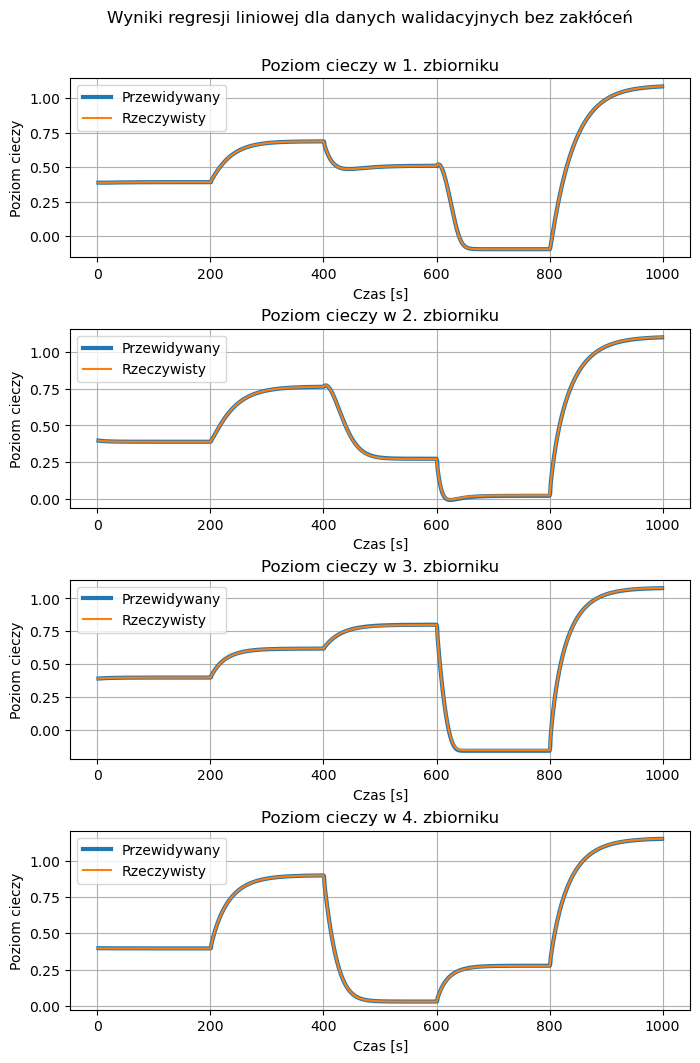

In [84]:
plot_model_result_all_tanks(df_val, model_type, dataset_name, "walidacyjnych")

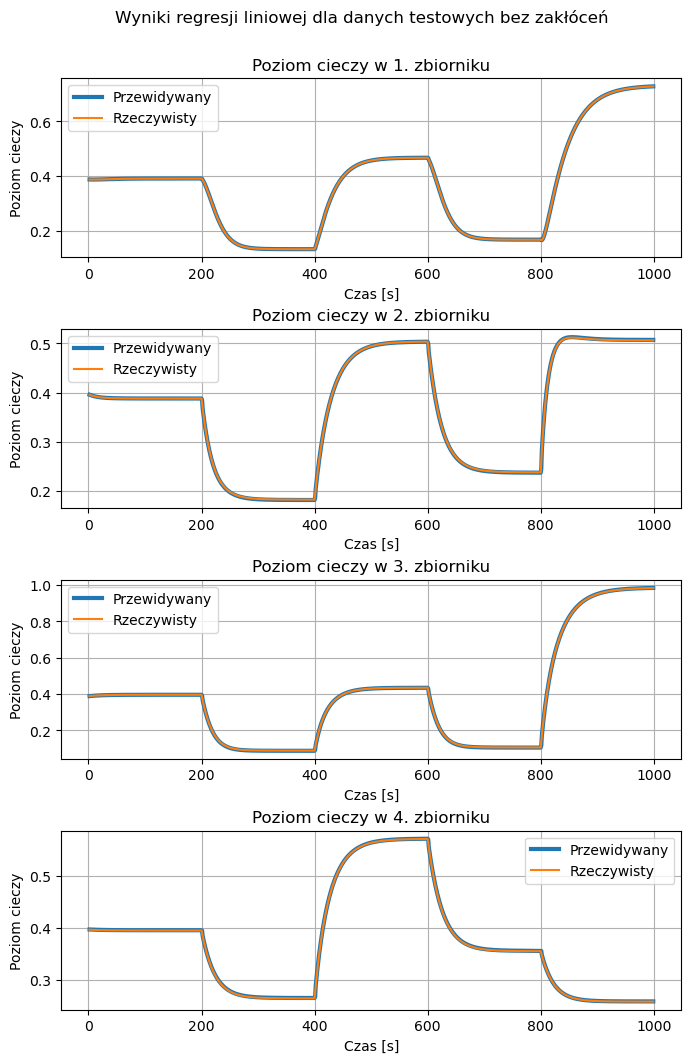

In [85]:
plot_model_result_all_tanks(df_test, model_type, dataset_name, "testowych")